# Leveraging ancestral sequence reconstruction for protein representation learning

In [2]:
import sys
sys.path.append("./")

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pickle as pkl
import os
import seaborn as sns

from lase_tx import (
    data_processing,
    lase_model,
    training,
)
from evolution import in_silico_lase
from spectral_decomposition import fourier_decomp

In [3]:
# lase parameters
n_layers = 6
hidden_dim = 128
num_heads = 4
vocab_size = 20
dropout_pr = 0.1

In [4]:
# PLM training data
asr_fasta = Path("../All_combined_processed_ancs_NR100.fasta")
save_dir = Path("../output")

# get max seq len
asr_seq_arr = data_processing.prepare_seqs(fasta_path=asr_fasta)
max_seq_len = asr_seq_arr.shape[1]

# regression data
reg_path = Path("./data/PTE_training_dset.csv")

# in silico data
start_seqs = [
    "MQTRRVVLKSAAAAGTLLGGLAGCASVAGSIGTGDRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALAEKAVRGLRRARAAGVRTIVDVSTFDIGRDVSLLAEVSRAADVHIVAATGLWFDPPLSMRLRSVEELTQFFLREIQYGIEDTGIRAGIIKVATTGKATPFQELVLRAAARASLATGVPVTTHTAASQRGGEQQAAIFESEGLSPSRVCIGHSDDTDDLSYLTALAARGYLIGLDHIPHSAIGLEDNASASALLGIRSWQTRALLIKALIDQGYMKQILVSNDWLFGFSSYVTNIMDVMDSVNPDGMAFIPLRVIPFLREKGVPQETLAGITVTNPARFLSPTLRAS",
    "MQTRRVVLKSAAAAGTLLGGLAGCASVAGSIGTGDRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALAEKAVRGLRRARAAGVRTIVDVSTFDLGRDVSLLAEVSRAADVHIVAATGLWLDPPLSMRLRSVEELTQFFLREIQYGIEDTGIRAGIIKVATTGKVTPFQELVLRAAARASLATGVPVTTHTAASQRGGEQQAAIFESEGLSPSRVCIGHSDDTDDLSYLTALAARGYLIGLDHIPHSAIGLEDNASASALLGIRSWQTRALLIKALIDQGYMKQILVSNDWLFGFSSYVTNIMDVMDSVNPDGMAFIPLRVIPFLREKGIPQETLAGITVTNPARFLSPTLRAS"
]
mut_dict = json.load(open(Path("./data/mutation_dict.json"), "r"))
mut_dict = {int(key): value for key, value in mut_dict.items()}

In [5]:
print(f"Number of ancestral training sequences: \t{asr_seq_arr.shape[0]}")
print(f"Maximum sequence length: \t\t\t{asr_seq_arr.shape[1]}")

Number of ancestral training sequences: 	10148
Maximum sequence length: 			365


## PLM training

In [9]:
# build encoder model 
encoder = training.build_encoder(
    n_layers,
    hidden_dim,
    num_heads,
    max_seq_len,
    dropout_pr,
)

# train and save model
training.train_encoder(
    encoder=encoder,
    fasta_path=asr_fasta,
    weight_dir=os.path.join(save_dir, "weights"),
    init_seed=0,
    max_epochs=1   # generally we train for about 25+ epochs
)

Model: "encoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional_embedding_1 (Po  multiple                  2816      
 sitionalEmbedding)                                              
                                                                 
 encoder_layer_6 (EncoderLa  multiple                  396032    
 yer)                                                            
                                                                 
 encoder_layer_7 (EncoderLa  multiple                  396032    
 yer)                                                            
                                                                 
 encoder_layer_8 (EncoderLa  multiple                  396032    
 yer)                                                            
                                                                 
 encoder_layer_9 (EncoderLa  multiple                  39

1it [00:02,  2.07s/it]

Training loss (for one batch) at step 0: 0.17085421085357666
Training accuracy (for one batch) at step 0:  0.050359711050987244


101it [02:59,  1.77s/it]

Training loss (for one batch) at step 100: 0.14905864000320435
Training accuracy (for one batch) at step 100:  0.09964105486869812


201it [05:56,  1.79s/it]

Training loss (for one batch) at step 200: 0.1069386750459671
Training accuracy (for one batch) at step 200:  0.1234850063920021


222it [06:34,  1.78s/it]


Validation accuracy (for one epoch) at epoch 0:  0.5281476378440857
Test accuracy at epoch 0: 0.5277575254440308


## Regression

Loading and viewing data:

In [11]:
# load regression sequences and labels

df = pd.read_csv(reg_path)
reg_seq_ls = df.Sequence.tolist()
reg_label_arr = df.Fitness.to_numpy()

reg_seq_arr = data_processing.prepare_seqs(seq_ls=reg_seq_ls)

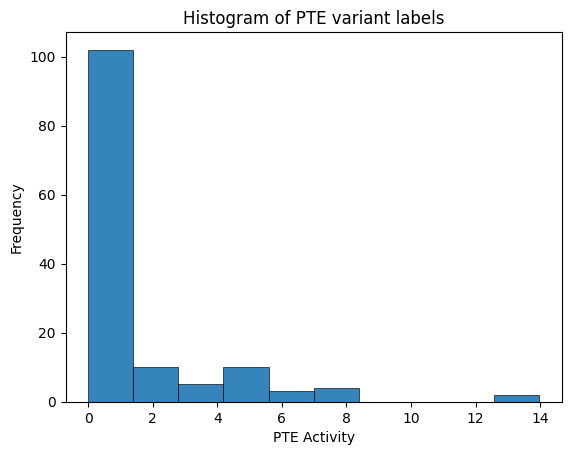

In [12]:
plt.hist(reg_label_arr, bins=10, linewidth=0.5, edgecolor="black", alpha=0.9)
plt.title("Histogram of PTE variant labels")
plt.xlabel("PTE Activity")
plt.ylabel("Frequency")
plt.show()

Getting LASE for PTE:

In [13]:
# load pre-trained model

encoder_model = lase_model.Encoder(
    n_layers,
    hidden_dim,
    num_heads,
    vocab_size,
    max_seq_len,
    dropout_pr,
)

encoder_model.load_weights(os.path.join(save_dir, "weights"))

# extract representations for regression data
_, rep_arr, _ = encoder_model(reg_seq_arr)

2024-01-08 12:54:30.781454: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [14]:
np.save(os.path.join(save_dir, "representations.npy"), rep_arr.numpy())
np.save(os.path.join(save_dir, "labels.npy"), reg_label_arr)

Training Scikit-learn regression models:

Scikit learn regressor models can be trained using the shell script `./sklearn_regressors/sklearn_parallel.sh` with the following usage:


**./sklearn_parallel.sh {path to representations} {output path} {path to labels}**

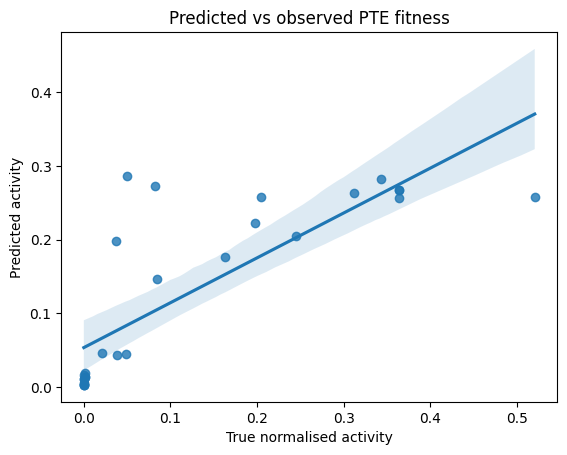

In [15]:
# load best sklearn model - requires manual assessment of model performance

skl_model = pkl.load(open("../output/regression/0/rf/final_model.sav", "rb"))

test_labels = np.load("../output/regression/0/rf/test_actual.npy")
test_predictions = np.load("../output/regression/0/rf/test_predictions.npy")

sns.regplot(x=test_labels, y=test_predictions)
plt.title("Predicted vs observed PTE fitness")
plt.xlabel("True normalised activity")
plt.ylabel("Predicted activity")
plt.show()

## *In Silico* Evolution

In [16]:
in_silico_lase.in_silico(
    start_seqs, 
    encoder_model, 
    32, 
    skl_model, 
    2, 
    mut_dict,
    save_dir
)

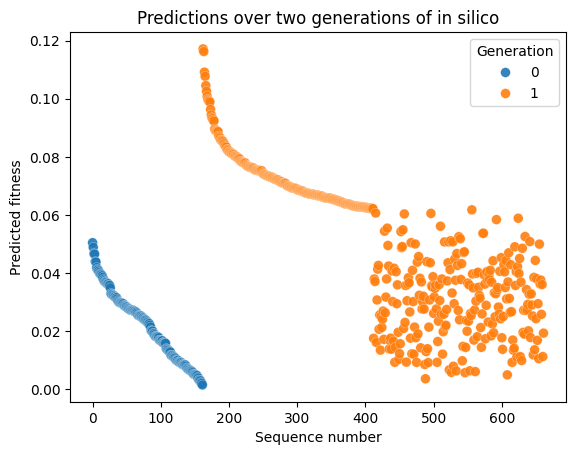

In [19]:
gen_0 = pd.read_csv("../output/LASE_insilico_predictions_0.csv")
gen_0["Generation"] = [0]*len(gen_0)
gen_1 = pd.read_csv("../output/LASE_insilico_predictions_1.csv")
gen_1["Generation"] = [1]*len(gen_1)
df = pd.concat((gen_0, gen_1))

sns.scatterplot(data=df, x=list(range(len(df))), y="predictions", hue="Generation", linewidth=0.2, s=50, alpha=0.9)
plt.title("Predictions over two generations of in silico")
plt.ylabel("Predicted fitness")
plt.xlabel("Sequence number")
plt.show() 

We see for each round the top 250 variants and a random 250 variants are included.

## Ruggedness

In [20]:
global_dirichlet = fourier_decomp.get_global_dirichlet_energy(rep_arr, reg_label_arr)
local_dirichlet_ls = fourier_decomp.get_local_dirichlet_energy(rep_arr, reg_label_arr)
eigenvals, eigenvecs, gft = fourier_decomp.graph_fourier_decomposition(rep_arr, reg_label_arr)

In [21]:
print(f"Global dirichlet energy: \t{global_dirichlet}")

Global dirichlet energy: 	54.26582686567407


Noting that a version of LASE trained on 1 epoch was used throughout this demo.